Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
- всего тестового набора данных (summary_plot - дать интерпретацию)
- для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

Ссылки:
- Пример с Permutation Importance - https://www.kaggle.com/dansbecker/permutation-importance
- Github проекта SHAP - https://github.com/slundberg/shap
- https://arxiv.org/pdf/1809.04559.pdf
- https://medium.com/civis-analytics/demystifying-black-box-models-with-shap-value-analysis-3e20b536fc80
- https://en.wikipedia.org/wiki/Shapley_value

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

from catboost import CatBoostClassifier, Pool

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('adult.data')
data.head(3)

,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K


- age: continuous.
- workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- fnlwgt: continuous.
- education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- education-num: continuous.
- marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- sex: Female, Male.
- capital-gain: continuous.
- capital-loss: continuous.
- hours-per-week: continuous.
- native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

In [3]:
data.columns

Index(['39', ' State-gov', ' 77516', ' Bachelors', ' 13', ' Never-married',
       ' Adm-clerical', ' Not-in-family', ' White', ' Male', ' 2174', ' 0',
       ' 40', ' United-States', ' <=50K'],
      dtype='object')

In [4]:
data.rename(columns={'39': 'age', ' State-gov': 'workclass', ' 77516': 'fnlwgt', ' Bachelors': 'education_level',
                     ' 13': 'education_num', ' Never-married': 'marital_status', ' Adm-clerical': 'occupation', 
                     ' Not-in-family': 'family', ' White': 'race', ' Male': 'Male', ' 2174': 'capital-gain', 
                     ' 0': 'capital-loss', ' 40': 'hours-per-week', ' United-States': 'native-country',
                     ' <=50K': 'target'}, inplace=True)

data['target'].replace({' <=50K': 0, ' >50K': 1}, inplace=True)
data['Male'].replace({' Female': 0, ' Male': 1}, inplace=True)

In [5]:
for col in data.columns:
    print(f'{col}: {np.sort(data[col].unique())}\n')

age: [17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64
 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88
 90]

workclass: [' ?' ' Federal-gov' ' Local-gov' ' Never-worked' ' Private'
 ' Self-emp-inc' ' Self-emp-not-inc' ' State-gov' ' Without-pay']

fnlwgt: [  12285   13769   14878 ... 1366120 1455435 1484705]

education_level: [' 10th' ' 11th' ' 12th' ' 1st-4th' ' 5th-6th' ' 7th-8th' ' 9th'
 ' Assoc-acdm' ' Assoc-voc' ' Bachelors' ' Doctorate' ' HS-grad'
 ' Masters' ' Preschool' ' Prof-school' ' Some-college']

education_num: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

marital_status: [' Divorced' ' Married-AF-spouse' ' Married-civ-spouse'
 ' Married-spouse-absent' ' Never-married' ' Separated' ' Widowed']

occupation: [' ?' ' Adm-clerical' ' Armed-Forces' ' Craft-repair' ' Exec-managerial'
 ' Farming-fishing' ' Handlers-cleaners' ' Machine-op-inspct'
 ' Other-

In [6]:
cat_features = ['workclass', 'education_level', 'marital_status', 'occupation', 'family', 'race', 'native-country']

In [7]:
data = pd.get_dummies(data, columns=cat_features, drop_first=True)
data.head(3)

,age,fnlwgt,education_num,Male,capital-gain,capital-loss,hours-per-week,target,workclass_ Federal-gov,workclass_ Local-gov,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,50,83311,13,1,0,0,13,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,38,215646,9,1,0,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,53,234721,7,1,0,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [8]:
data['target'].value_counts()

0    24719
1     7841
Name: target, dtype: int64

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('target', 1), data['target'],
                                                    stratify=data['target'], test_size=0.3, random_state=1)

In [10]:
model = CatBoostClassifier(depth=3, iterations=450, learning_rate=0.11, random_state=1, verbose=False)
model.fit(X_train, y_train)

preds = model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])

print('Best Threshold=%.3f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (
                                                                                              thresholds[ix],
                                                                                              fscore[ix],
                                                                                              precision[ix],
                                                                                              recall[ix]))

Best Threshold=0.370, F-Score=0.737, Precision=0.709, Recall=0.768


In [11]:
feature_impotance = pd.DataFrame({'feature_importance': model.get_feature_importance(Pool(X_train, y_train)),
                                  'feature_names': X_train.columns}).sort_values(by=['feature_importance'],
                                                                                 ascending=False)
feature_impotance[:15]

,feature_importance,feature_names
31,23.698542,marital_status_ Married-civ-spouse
4,22.429742,capital-gain
0,11.176575,age
2,10.667793,education_num
5,10.254861,capital-loss
6,5.739647,hours-per-week
52,1.645057,family_ Own-child
1,1.561630,fnlwgt
43,1.476623,occupation_ Other-service
3,1.146585,Male


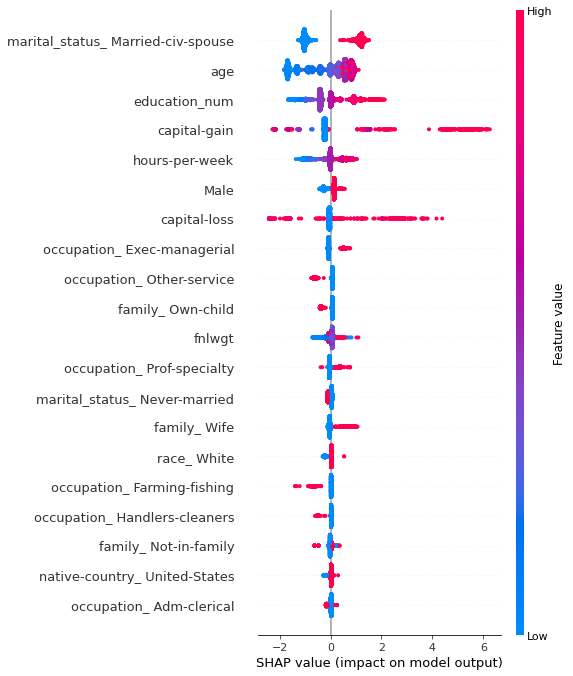

In [12]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

- marital_status (married-civ-spouse): если люди семейные, то их доход выше.
- age: меньший возраст снижает вероятность большого дохода
- male/female: у мужчин вероятность зарабатывать >50 чуть выше, чем у женщин
- capital-loss: высокие потери капитала изменяют вероятность в обе стороны
- family (wife): если у человека есть жена, его доход, вероятно, выше 

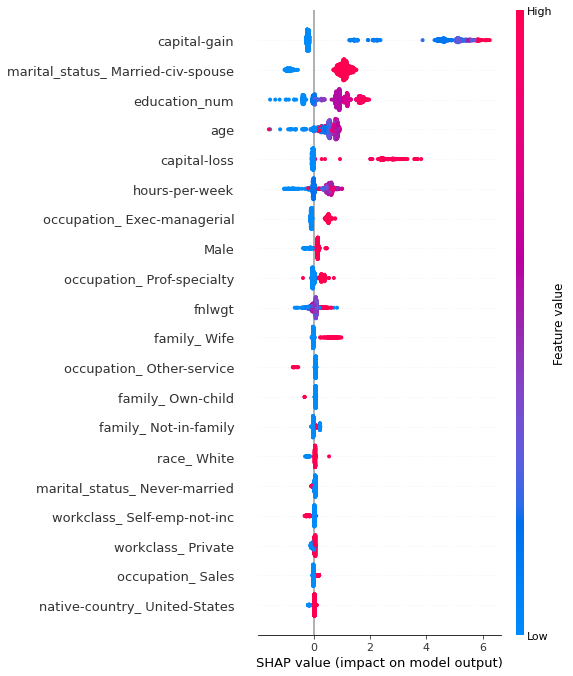

In [13]:
X_test['preds'] = preds
X_test.sort_values('preds', ascending=False, inplace=True)
idx_top10 = int(X_test.shape[0] * 0.10)

shap_values = explainer.shap_values(X_test[:idx_top10])
shap.summary_plot(shap_values, X_test[:idx_top10])

График немного изменился, но в целом  в топе те же признаки. Сильнее всего повышат вероятность дохода >50 прирост и потери капитала, наличие семьи, годы обучения, возраст и менеджерская работа.

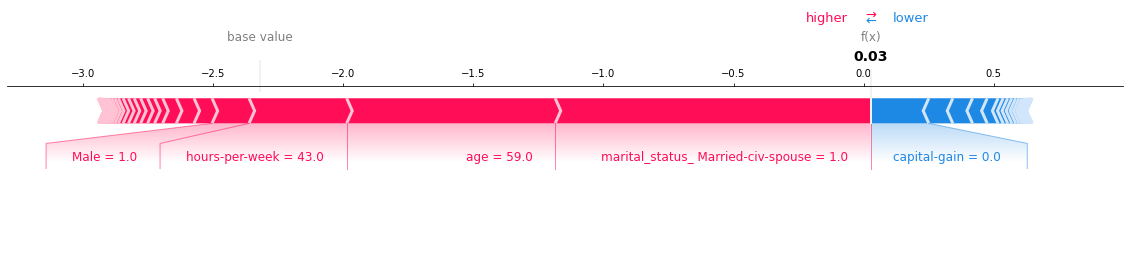

In [14]:
shap_values = explainer.shap_values(X_train)
idx=11
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_train.iloc[idx,:], matplotlib=True)

Взрослый мужчина, работающи полную ставку, имеющий семью. Эти признаки повышают вероятность дохода >50. А понижает ее нулевой прирост капитала.

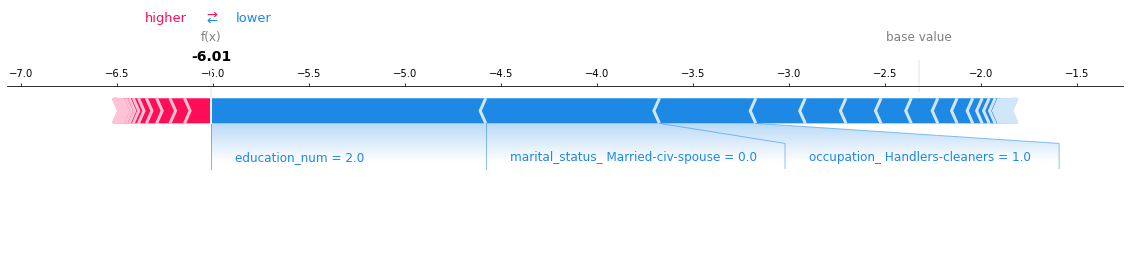

In [15]:
idx=13
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_train.iloc[idx,:], matplotlib=True)

Несемейный человек с двумя годами образования, работающий уборщиком. Эти признаки снижаю вероятность высокого заработка.

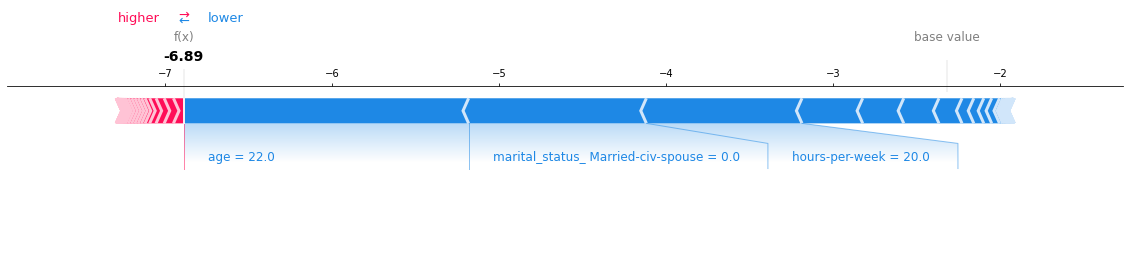

In [16]:
idx=24
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_train.iloc[idx,:], matplotlib=True)

Молодой человек без семьи, работающий полставки.

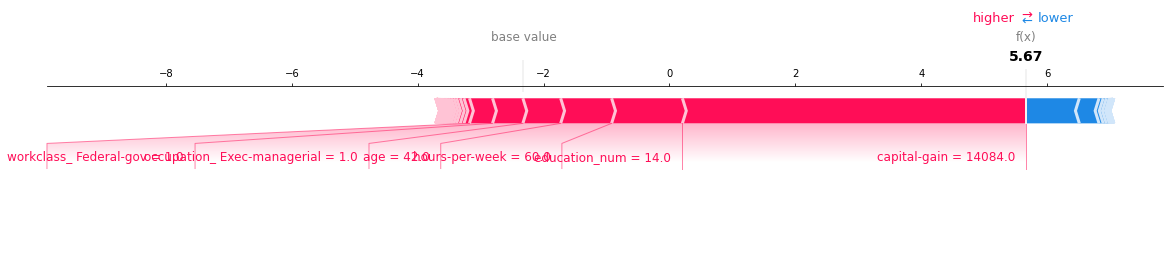

In [17]:
idx=22
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_train.iloc[idx,:], matplotlib=True)

Большой прирост капитала, 14 лет образования, зрелый возраст 42 года, работа в федеральном правительстве 60 часов в неделю. Значения этих признаков сильно увеличили вероятность причисления объекта к тем, чей доход >50